In [54]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

## SDRA

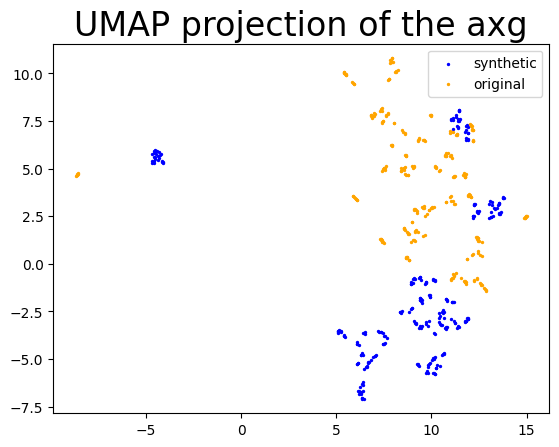

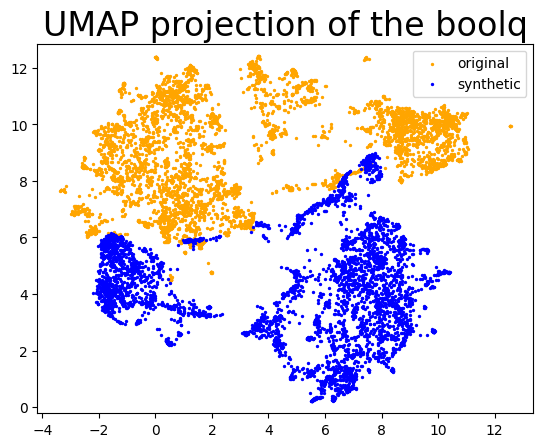

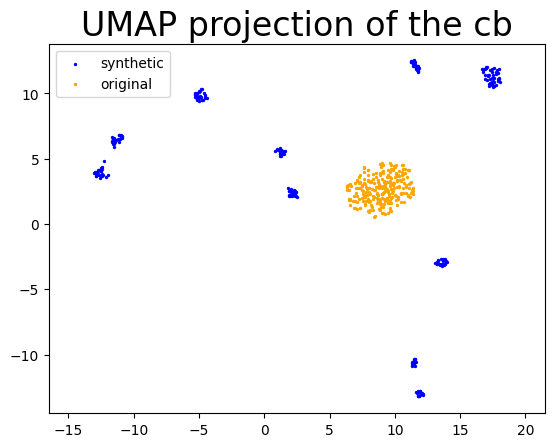

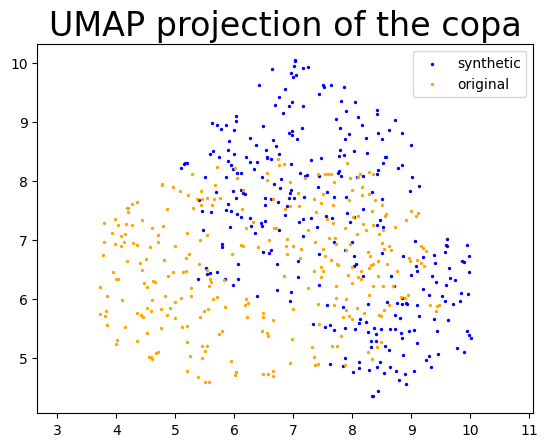

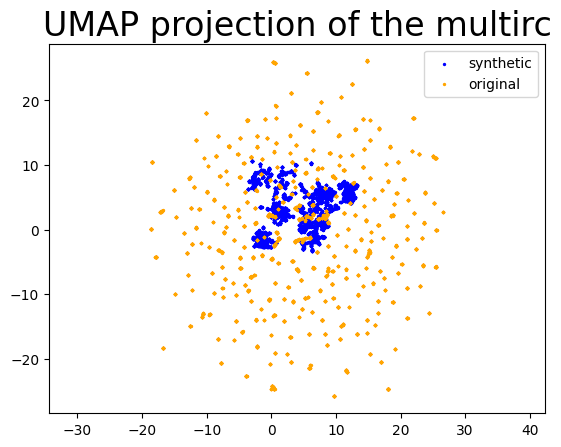

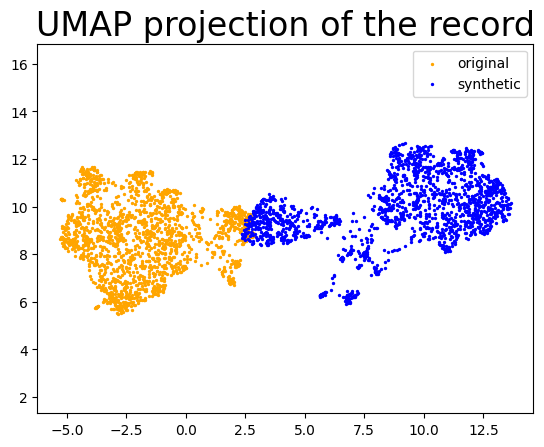

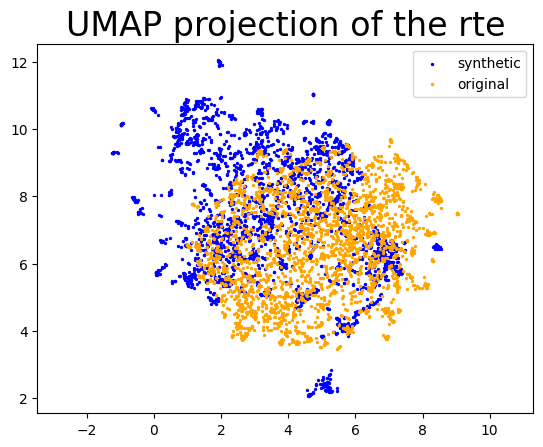

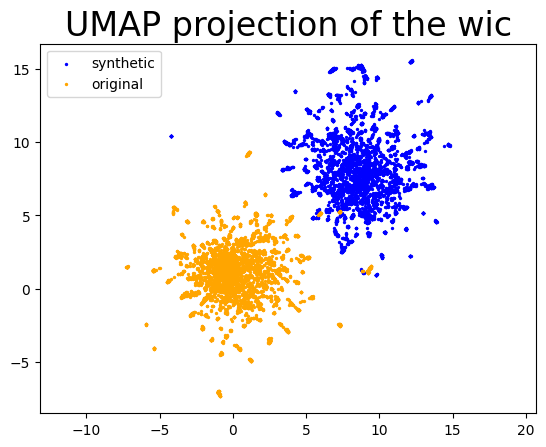

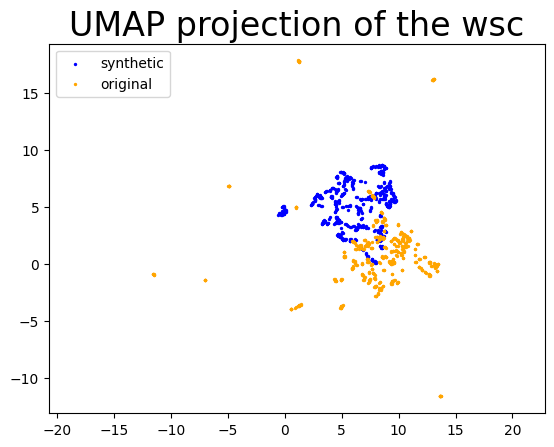

In [3]:
root_path = '/data/data/hgupta35/MuGEN/analysis_files/dataset_diversity'
s_val = 2

for dataset_name in ['axg', 'boolq', 'cb', 'copa', 'multirc', 'record', 'rte', 'wic', 'wsc']:

    plt.figure()
    for file in os.listdir(os.path.join(root_path, 'embeddings')):
        
        if dataset_name in file and 'original' in file:
            with open(os.path.join(root_path, 'embeddings', f'sdra_emb_{dataset_name}_original.pkl'), 'rb') as f:
                density_reduced_embeddings = pickle.load(f)

            plt.scatter(
                    density_reduced_embeddings[:, 0],    
                    density_reduced_embeddings[:, 1],
                    label = 'original',
                    color='orange',
                    s=s_val
                    )

        if dataset_name in file and 'synthetic' in file:
            with open(os.path.join(root_path, 'embeddings', f'sdra_emb_{dataset_name}_synthetic.pkl'), 'rb') as f:
                density_reduced_embeddings = pickle.load(f)

            plt.scatter(
                    density_reduced_embeddings[:, 0],    
                    density_reduced_embeddings[:, 1],
                    label = 'synthetic',
                    color='blue',
                    s=s_val
                    )
            
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of the {dataset_name}', fontsize=24)


    plt.legend()
    plt.savefig(os.path.join(root_path, "plots", f"sdra_{dataset_name}.png"), dpi=300, bbox_inches='tight')

## Density Plots

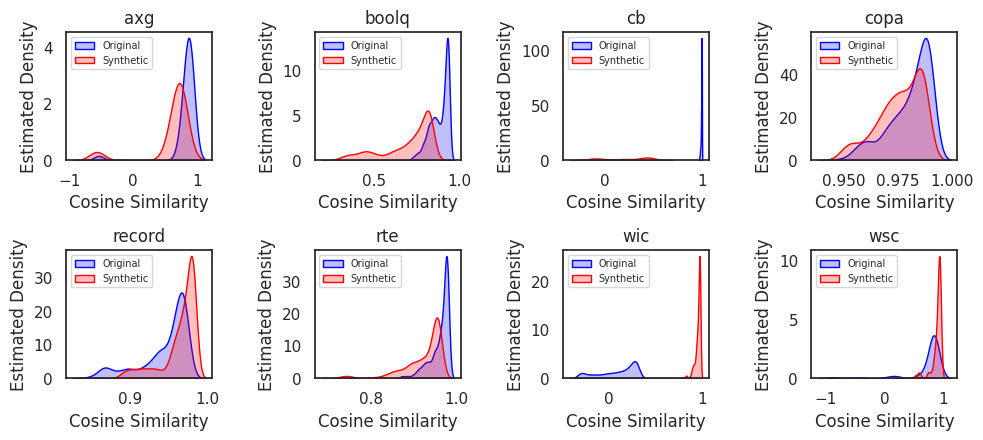

In [147]:
root_path = "/data/data/hgupta35/MuGEN/analysis_files/dataset_diversity/embeddings"
embedding_files =sorted(os.listdir(root_path))

diversity_map = {}
for emb_file in embedding_files:
    file_path = os.path.join(root_path, emb_file)
    with open(file_path, 'rb') as f:
        density_reduced_embeddings = pickle.load(f)

    dataset_similarity_values = []
    for i in range(density_reduced_embeddings.shape[0]):

        # Get the current row
        current_row = density_reduced_embeddings[i, :]
        
        # Get the array without the current row
        array_without_current_row = np.delete(density_reduced_embeddings, i, axis=0)

        # Compute cosine similarity
        cosine_sim = np.mean(cosine_similarity(current_row.reshape(-1, 2), array_without_current_row))

        dataset_similarity_values.append(cosine_sim)
    
    diversity_map[emb_file.split('.')[0]] = dataset_similarity_values

# Create a 2x4 subplot grid
fig, axs = plt.subplots(2, 4, figsize=(11.5, 4.5))
fig.subplots_adjust(hspace=0.7, wspace=0.7)

embedding_file_list = []
for j in range(0, len(embedding_files), 2):
    orig = embedding_files[j].split('.')[0]
    synth = embedding_files[j+1].split('.')[0]
    if 'multirc'  not in orig:
        embedding_file_list.append([orig, synth])

# Loop through datasets and titles
for i, val in enumerate(embedding_file_list):

    # Load the data as dataframe
    max_idx = min(len(diversity_map[val[0]]), len(diversity_map[val[1]]))
    tdf = pd.DataFrame({'original': diversity_map[val[0]][:max_idx], 'synthetic': diversity_map[val[1]][:max_idx]})

    # Calculate subplot position
    row = i // 4
    col = i % 4

    # Select the current subplot
    ax = axs[row, col]

    # Set plot labels and title for the current subplot
    ax.set_ylabel('Estimated Density')
    ax.set_xlabel('Cosine Similarity')

    # Create a distribution plot for the current dataset
    sns.kdeplot(data=tdf, x='original', color='blue', label='Original', fill=True, ax=ax)
    sns.kdeplot(data=tdf, x='synthetic', color='red', label='Synthetic', fill=True, ax=ax)

    # Add a legend to the current subplot
    ax.legend(loc='upper left', fontsize=7)
    ax.set_title(val[0].split('_')[2])

# Show the plot
plt.savefig(f"/data/data/hgupta35/MuGEN/analysis_files/dataset_diversity/cosine_sim.png", dpi=300, bbox_inches='tight')
plt.show()